In [1]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.contrib import rnn
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import sklearn
print tf.__version__
print sklearn.__version__

1.0.1
0.18.1


In [9]:
collapsed_shifted = pd.read_csv('data/collapsed_shifted.csv', header = 0)
collapsed_shifted.reset_index(drop = True,inplace = True)
security_return = pd.read_csv('data/security_return.csv',header = 0)
security_return.reset_index(drop = True,inplace = True)

In [10]:
collapsed_shifted = collapsed_shifted.merge(security_return,on = 'Date')
collapsed_shifted.set_index('Date',inplace = True)
security_return.set_index('Date',inplace = True)

In [4]:
security_return.head(5)

,Adj Close
Date,
2000-07-03,14.940063
2000-07-05,-23.310059
2000-07-06,10.440064
2000-07-07,22.229980
2000-07-10,-3.280029


In [14]:
print ('Creating train test split...')
test_size = 0.15
print ('Train Test split without shuffling percentage %.2f' % test_size)
X_train = collapsed_shifted.iloc[:int(len(collapsed_shifted)*(1-test_size))]
X_test = collapsed_shifted.iloc[int(len(collapsed_shifted)*(1-test_size)):]
Y_train = security_return.iloc[:int(len(collapsed_shifted)*(1-test_size))]
Y_test = security_return.iloc[int(len(collapsed_shifted)*(1-test_size)):]
# X_train,X_test,Y_train,Y_test = train_test_split(collapsed_shifted,security_return,stratify=None,test_size=.10)
#X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,test_size=.20,stratify=None,shuffle=False)

#Creating Copies of Data Frames these will be useful later for debugging
X_train_df = X_train.copy(True)
Y_train_df = Y_train.copy(True)
X_train  = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

Creating train test split...
Train Test split without shuffling percentage 0.15


In [33]:
print 'training data in total %i' % len(X_train)
print 'testing data in total %i' % len(X_test)

training data in total 3692
testing data in total 652


In [15]:
class Batch(object):
    def __init__(self, inputs, labels, batch_size = 16, seq_lens = 7, shuffle = False):
        self.inputs = inputs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.seq_lens = seq_lens
        
    def get_batch(self, step):
        '''process one batch for training
        Args:
            X: 1->T Y:1->T-1 label: T
        '''
        
        X = [np.expand_dims(self.inputs[step+i:step+self.seq_lens+i],0) for i in range(self.batch_size)]
        X_batch = np.concatenate(X,axis = 0)
        Y = [np.expand_dims(self.labels[step+i:step+self.seq_lens+i],0) for i in range(self.batch_size)]
        Y_batch = np.squeeze(np.concatenate(Y,axis = 0))
        labels = np.array([self.labels[step+self.seq_lens+i] for i in range(self.batch_size)]).reshape(-1,1)
        
        if self.shuffle:
            index = range(self.batch_size)
            np.random.shuffle(index)
            X_batch = X_batch[index]
            y_batch = Y_batch[index]
            labels = labels[index]
        return X_batch, Y_batch, labels

In [16]:
# batch = Batch(X_train,Y_train,batch_size = 16, seq_lens = 7, shuffle = True)
# X,Y,labels = batch.get_batch(0)

In [17]:
class ts_prediction(object):
    
    def __init__(self, input_dim, time_step, n_hidden, d_hidden, batch_size, is_train = True):

        self.batch_size = batch_size
        self.n_hidden = n_hidden
        self.d_hidden = d_hidden
        self.is_train = is_train # for dropout
        self.input_dim = input_dim
        self.time_step = time_step
        self.seq_len = tf.placeholder(tf.int32,[None])
        self.input_x = tf.placeholder(dtype = tf.float32, shape = [None, self.time_step, input_dim]) # b,T,d_in
        self.input_y = tf.placeholder(dtype = tf.float32,shape = [None,self.time_step]) # b,T
        self.label = tf.placeholder(dtype = tf.float32, shape = [None,1]) #b,1
        self.original_loss = tf.placeholder(dtype = tf.float32, shape = [])
        ## placeholder for loss without adversarial gradient added
        
        self.encode_cell = tf.contrib.rnn.LSTMCell(self.n_hidden, forget_bias=1.0, state_is_tuple=True)
        self.decode_cell = tf.contrib.rnn.LSTMCell(self.d_hidden, forget_bias=1.0, state_is_tuple=True)
        #self.output_cell = tf.contrib.rnn.LSTMCell(self.o_hidden, forget_bias=1.0, state_is_tuple=True)
        
        self.loss_1 = tf.constant(0.0)
        self.loss = tf.constant(0.0)
        self.rand_unif_init = tf.random_uniform_initializer(-0.1, 0.1)
            ## ===========  build the model =========== ##
        self.global_step = tf.Variable(0,dtype = tf.int32, name = 'global_step', trainable = False)
            ## ==== encoder ===== ## 
        h_encode, c_state = self.en_RNN(self.input_x, scopes = 'fw_lstm')
        attn_dists = self._attention_encoder(h_encode, c_state, self.input_x) # b,T,D
        
        encoded_input = tf.multiply(self.input_x,attn_dists)
        encoded_input.set_shape([None,self.time_step,input_dim])
        h_t, c_t = self.en_RNN(encoded_input, scopes = 'fw_lstm')

        h_decode, d_state = self.de_RNN(tf.expand_dims(self.input_y,-1))
        
        d_expand = tf.tile(tf.expand_dims(d_state[1],1),[1,self.time_step,1])
        dec_lstm = tf.concat([h_decode,d_expand],axis = 2) # b,T,2*d_hidden
        
        stddev = 1.0/(self.n_hidden*self.time_step)
        Ud = tf.get_variable(name = 'Ud', dtype = tf.float32, shape = [self.n_hidden, self.n_hidden],
                             initializer = tf.random_normal_initializer(mean = 0.0, stddev = stddev))
        
        brcast_UDX = tf.matmul(h_t,tf.tile(tf.expand_dims(Ud,0),[self.batch_size,1,1])) # b,T,n_hidden
        
        l_list = []
        for i in range(self.time_step):
            feature_i = brcast_UDX[:,i,:]
            l_i = self.dec_attention(dec_lstm,feature_i)
            l_list.append(l_i)
        l_mat = tf.concat(l_list,axis = 2)
        beta_mat = tf.nn.softmax(l_mat, dim = 1)
        context_list = []
        h_tmp = tf.transpose(h_t,[0,2,1])

        for t in range(self.time_step):
            beta_t = tf.reshape(beta_mat[:,t,:],[self.batch_size,1,self.time_step])
            c_t = tf.reduce_sum(tf.multiply(h_tmp,beta_t),2) # b,T,T -> b,T,1
            context_list.append(c_t)
        c_context = tf.stack(context_list,axis = 2) # b,n_hidden,T
        # b,T,1 b,T,n_hidden -> b,T,n_hidden+1
        c_concat = tf.concat([tf.expand_dims(self.input_y,-1),tf.transpose(c_context,[0,2,1])], axis = 2)
        W_hat = tf.get_variable(name = 'W_hat', dtype = tf.float32,shape = [self.n_hidden+1,1],
                                initializer = tf.random_normal_initializer(mean = 0.0, stddev = stddev))
                                #initializer = tf.truncated_normal(mean = 0.0, stddev = stddev))
                                
        y_encode = tf.matmul(c_concat,tf.tile(tf.expand_dims(W_hat,0),[self.batch_size,1,1]))
        
        
        h_out, d_out = self.de_RNN(y_encode) #b,T,d_hidden; b,d_hidden
        
      
        dc_concat = tf.concat([h_out[:,-1,:],d_out.c],axis = 1) # b,2*d_hidden
        dense_layer_1 = tf.layers.dense(dc_concat, activation = None, units = self.n_hidden, name = 'dense_layer1')
        if self.is_train:
            dropout_keep_prob = 0.5
        else:
            dropout_keep_prob = 1
        dense_dropout = tf.nn.dropout(dense_layer_1, dropout_keep_prob)
        dense_layer_2 = tf.layers.dense(dense_dropout, activation = None, units = self.n_hidden, name = 'dense_layer2')
        
        self.y_predict = tf.squeeze(tf.layers.dense(dense_layer_2, units = 1)) # b, 1
        #self.original_loss = tf.reduce_mean(tf.square(self.label - self.y_predict)) # reduce_mean: avg of batch loss
        loss = tf.reduce_mean(tf.square(self.label - self.y_predict))
        self.loss = loss
        #self.loss_1 += tf.reduce_mean(tf.square(self.label - self.y_predict)) # reduce_mean: avg of batch loss
        #self.adversarial_gradient = tf.gradients(self.loss_1,self.input_x)
        #self.loss = self.loss_1 + self.original_loss
        
        tvars = tf.trainable_variables()
        optimizer = tf.train.AdamOptimizer(5e-6)
        #optimizer = tf.train.AdagradOptimizer(5e-3)
        #self.train_op = optimizer.minimize(self.loss,global_step = self.global_step)
        #grad_var = optimizer.compute_gradients(loss = self.loss, var_list = self.params, aggregation_method = 2)
        gradients = tf.gradients(self.loss, tvars, aggregation_method=tf.AggregationMethod.EXPERIMENTAL_TREE)
        self.train_op = optimizer.apply_gradients(zip(gradients, tvars), global_step = self.global_step)
        
        
    def en_RNN(self, input_x, scopes = 'fw_lstm'):
        '''
        input_x: b, T, d_in
        
        output: h:       seqence of output state b,T,n_hidden
                state:   final state b,n_hidden
                
        '''
        with tf.variable_scope('fw_lstm' or scopes) as scope:
            try:
                h,state = tf.nn.dynamic_rnn(cell = self.encode_cell, inputs = input_x,
                                            sequence_length = self.seq_len, dtype = tf.float32, scope = 'fw_lstm')
                
            except ValueError:
                scope.reuse_variables()
                h,state = tf.nn.dynamic_rnn(cell = self.encode_cell, inputs = input_x, 
                                            sequence_length = self.seq_len, dtype = tf.float32, scope = scopes)
        
        return [h,state]
    
    def de_RNN(self,input_y, scopes = 'de_lstm'):
        
        with tf.variable_scope('dec_lstm') as scope:
            try:
                h,state = tf.nn.dynamic_rnn(
                    cell = self.decode_cell, inputs = input_y,
                    sequence_length = self.seq_len,
                    dtype = tf.float32, scope = 'de_lstm')
                
            except ValueError:
                scope.reuse_variables()
                h,state = tf.nn.dynamic_rnn(
                    cell = self.decode_cell, inputs = input_y,
                    sequence_length = self.seq_len,
                    dtype = tf.float32, scope = scopes)
        
        return [h,state]
    
    def en_attention(self,fw_lstm,feature_k):
        '''
        fw_lstm: b,T,2n
        feature_k: row k from brcast_UX, b,T
        
        return: b,T
        '''
        with tf.variable_scope('encoder') as scope:
            try:
                mean = 0.0
                stddev = 1.0/(self.n_hidden*self.time_step)
                We = tf.get_variable(name = 'We', dtype=tf.float32,shape = [self.time_step, 2*self.n_hidden],
                                     initializer=tf.truncated_normal_initializer(mean,stddev))
                Ve = tf.get_variable(name = 'Ve',dtype=tf.float32,shape = [self.time_step,1],
                                     initializer=tf.truncated_normal_initializer(mean,stddev))
            except ValueError:
                scope.reuse_variables()
                We = tf.get_variable('We')
                Ve = tf.get_variable('Ve')   
            # (b,T,2n) (b,2n,T)
        W_e = tf.transpose(tf.tile(tf.expand_dims(We,0),[self.batch_size,1,1]),[0,2,1]) # b,2n,T
        mlp = tf.nn.tanh(tf.matmul(fw_lstm,W_e) + tf.reshape(feature_k,[self.batch_size,1,self.time_step])) #b,T,T + b,1,T = b,T,T
        V_e = tf.tile(tf.expand_dims(Ve,0),[self.batch_size,1,1])
        return  tf.matmul(mlp,V_e)
            
    def dec_attention(self, dec_lstm, feature_t, scopes = None):
        '''
        dec_lstm: b,T,2*d_hidden
        feature_k: row k from brcast_UX, b,T
        
        return: b,T
        '''
        with tf.variable_scope('decoder' or scopes) as scope:
            try:
                mean = 0.0
                stddev = 1.0/(self.n_hidden*self.time_step)
                Wd = tf.get_variable(name = 'Wd', dtype=tf.float32, shape = [self.n_hidden, 2*self.d_hidden],
                                     initializer=tf.truncated_normal_initializer(mean,stddev))
                Vd = tf.get_variable(name = 'Vd', dtype=tf.float32, shape = [self.n_hidden,1],
                                     initializer=tf.truncated_normal_initializer(mean,stddev))
            except ValueError:
                scope.reuse_variables()
                Wd = tf.get_variable('Wd')
                Vd = tf.get_variable('Vd')   
        # (b,T,2*d_hidden) (b,2*d_hidden,T)
        W_d = tf.transpose(tf.tile(tf.expand_dims(Wd,0),[self.batch_size,1,1]),[0,2,1]) # b,2*d_hidden,n_hidden
        # (b,T,2*d_hidden) * (b,2*d_hidden,n_hidden) -> b,T,n_hidden
        mlp = tf.nn.tanh(tf.matmul(dec_lstm,W_d) + tf.reshape(feature_t,[self.batch_size,1,self.n_hidden])) #b,T,n_hidden + b,1,n_hidden = b,T,n_hidden
        V_d = tf.tile(tf.expand_dims(Vd,0),[self.batch_size,1,1])
        return  tf.matmul(mlp,V_d) #b,T,1
    
    def predict(self,x_test,y_test,sess):
        
        train_seq_len =  np.ones(self.batch_size) * self.time_step
        feed = {model.input_x: x_test, 
                model.seq_len: train_seq_len,
                model.input_y: y_test}
        y_hat = sess.run(self.y_predict,feed_dict = feed)
        return y_hat.reshape(-1)
    
    def _attention_encoder(self, enc_hiddens, enc_last_state, inputs):

        #hps = self._hps
        with tf.variable_scope('attn_encoder') as scope:
            cell_state = enc_last_state.c # b,enc_hidden
            cell_states = tf.tile(tf.expand_dims(cell_state,axis = 1),[1,self.time_step,1]) #b,T,enc_hidden
            enc_concat = tf.expand_dims(tf.concat([enc_hiddens,cell_states], axis = 2),2) # b,T,1,2*enc_hidden


            U_e = tf.get_variable(dtype= tf.float32, shape = [self.time_step, self.time_step],
                                  initializer = self.rand_unif_init, name = 'U_e') # T,T
            V_e = tf.get_variable(dtype= tf.float32, shape = [self.time_step,1],
                                  initializer = self.rand_unif_init, name = 'V_e') # T,T
            broad_V_e = tf.tile(tf.expand_dims(V_e,0),[self.batch_size,1,1]) # b,T,1
            # Ue*X
            broad_U_e = tf.tile(tf.expand_dims(U_e,0),[self.batch_size, 1,1]) # b,T,T
            broad_mat = tf.matmul(broad_U_e, inputs) #b,T,D
            # We*[h,s]
            W_e = tf.get_variable(dtype= tf.float32, shape = [1,1,self.n_hidden*2, self.time_step],
                                  initializer = self.rand_unif_init, name = 'W_e') # 1,1,2*n_hidden, T
            encoder_features = tf.squeeze(tf.nn.conv2d(enc_concat, filter=W_e, strides = [1,1,1,1], padding = 'SAME')) # b,T,T    

            attn_dists = []
            for t in range(self.time_step):
                mat_sum = tf.expand_dims(encoder_features[:,t,:],-1) + broad_mat
                e_tk = tf.multiply(broad_V_e,mat_sum) #b,T,D
                e_t = tf.reduce_sum(e_tk,axis = 1) # b,D
                attn_dists.append(tf.nn.softmax(e_t))
            return tf.stack(attn_dists, axis = 1) # b,T,D

In [18]:
def get_config():
    '''return config for tf.Session'''
    config = tf.ConfigProto(allow_soft_placement = True)
    config.gpu_options.allow_growth = True
    
    return config

In [25]:
batch_size = 16
INPUT_DIM = 13  # 12 input features
seq_lens = time_step = 7 # 7 consecutive days to predict next day stock returns
n_hidden = 32 # encoder dim
d_hidden = 32 # decoder dim
# train_dir = './ts_traindir'
## o_hidden = 16 default

current_episode = 0
total_episodes = 40

steps = int(len(X_train)/batch_size)

tf.reset_default_graph()
model = ts_prediction(input_dim = INPUT_DIM, time_step = seq_lens, n_hidden= n_hidden, d_hidden = d_hidden, batch_size = batch_size)
model.is_train = True
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
# sv = tf.train.Supervisor(logdir=train_dir,
#                              is_chief=True,
#                              saver=saver,
#                              summary_op=None,
#                              save_summaries_secs=120, # save summaries for tensorboard every 120 secs
#                              save_model_secs=300, # checkpoint every 120 secs
#                              global_step=model.global_step)
# tf.logging.info("Preparing or waiting for session...")
# sess_context_manager = sv.prepare_or_wait_for_session(config=get_config())
# with sess_context_manager as sess:

batch = Batch(X_train,Y_train,batch_size = batch_size, seq_lens = seq_lens, shuffle = True)
#X,Y,labels = batch.get_batch(step = 0)
while current_episode<=total_episodes:
    cumulative_loss = 0.0

    for t in range(steps):

        x,y,labels = batch.get_batch(step = t)
        train_seq_len =  np.ones(batch_size) * seq_lens
        feed = {model.input_x: x, 
                model.seq_len: train_seq_len,
                model.input_y: y,
                model.label: labels}
        #loss_1, adversarial_gradients = sess.run([model.loss_1,model.adversarial_gradient],feed_dict = feed)
        loss, _, train_steps = sess.run([model.loss,model.train_op, model.global_step],feed_dict = feed)
#         epsilon = np.random.uniform(0,0.5,1)
#         feed = {model.input_x: x + epsilon*adversarial_gradients[0], 
#                 model.seq_len: train_seq_len,
#                 model.input_y: y,
#                 model.label: labels,
#                 model.original_loss: loss_1}
#         loss, _, train_steps = sess.run([model.loss, model.train_op, model.global_step], feed_dict = feed)

        cumulative_loss += loss

        if train_steps % 100 == 0:
            tf.logging.info('%i epoch, 100 steps, losses per batch are %.4f', current_episode, cumulative_loss*1.0/100)
            #print "current_episode %i, steps %i, losses are %f" % ( current_episode, t, cumulative_loss)
            cumulative_loss = 0.0
    current_episode+=1

INFO:tensorflow:0 epoch, 100 steps, losses per batch are 283.7468
INFO:tensorflow:0 epoch, 100 steps, losses per batch are 386.3157
INFO:tensorflow:1 epoch, 100 steps, losses per batch are 167.7008
INFO:tensorflow:1 epoch, 100 steps, losses per batch are 380.7504
INFO:tensorflow:2 epoch, 100 steps, losses per batch are 51.4595
INFO:tensorflow:2 epoch, 100 steps, losses per batch are 377.7057
INFO:tensorflow:3 epoch, 100 steps, losses per batch are 19.8662
INFO:tensorflow:3 epoch, 100 steps, losses per batch are 322.3957
INFO:tensorflow:3 epoch, 100 steps, losses per batch are 346.1201
INFO:tensorflow:4 epoch, 100 steps, losses per batch are 199.8327
INFO:tensorflow:4 epoch, 100 steps, losses per batch are 404.7792
INFO:tensorflow:5 epoch, 100 steps, losses per batch are 71.8631
INFO:tensorflow:5 epoch, 100 steps, losses per batch are 378.9297
INFO:tensorflow:6 epoch, 100 steps, losses per batch are 31.7705
INFO:tensorflow:6 epoch, 100 steps, losses per batch are 367.3325
INFO:tensorflo

In [26]:
steps_test = int(len(X_test)/batch_size)
test_loss = 0.0
y_hat_arr = np.empty(shape = [0])
y_labels_arr = np.empty(shape = [0])
batch = Batch(X_test,Y_test,batch_size = 16, seq_lens = 7, shuffle = False)
model.is_train = False
for t in range(steps_test):
    
    x_test,y_test,labels_test = batch.get_batch(step = t)
    labels_test = labels_test.reshape(-1)
    y_hat = model.predict(x_test,y_test,sess) 
    y_hat_arr = np.concatenate([y_hat_arr,np.array(y_hat)])
    y_labels_arr = np.concatenate([y_labels_arr,np.array(labels_test)])
    test_loss += np.mean(np.square(y_hat - labels_test))

print "the mean squared error for test data are %f " % (test_loss*1.0/steps_test)

the mean squared error for test data are 177.417104 


/usr/lib64/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


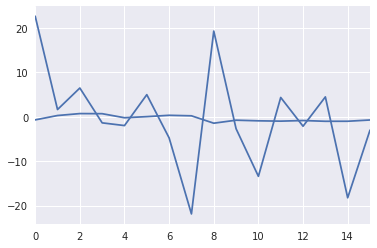

In [27]:
sns.tsplot(data = y_hat)
sns.tsplot(data = labels_test)

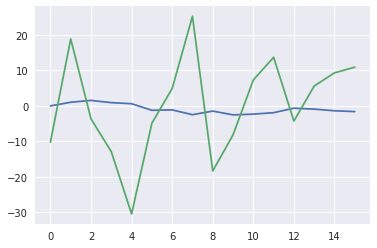

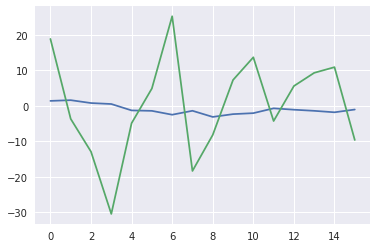

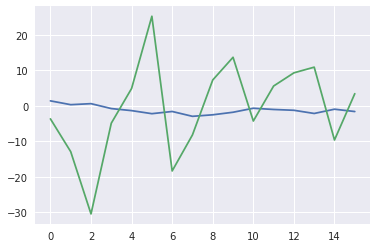

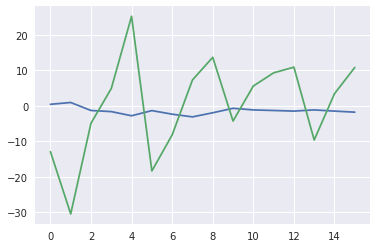

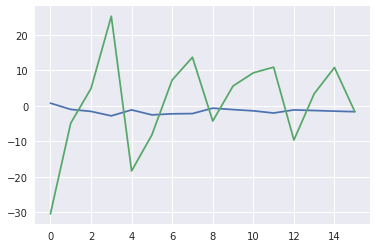

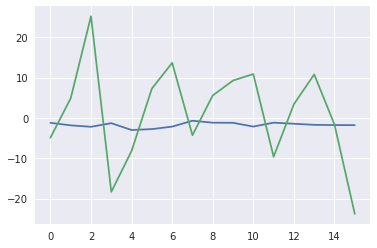

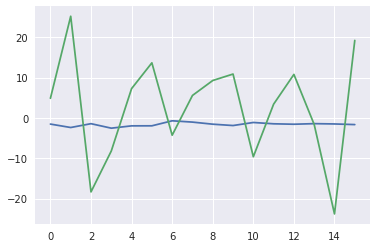

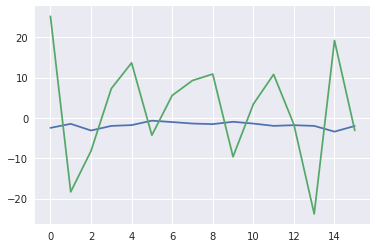

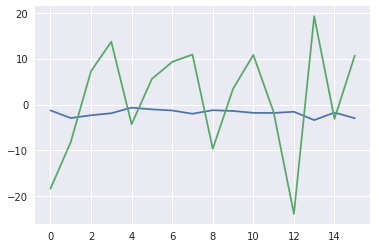

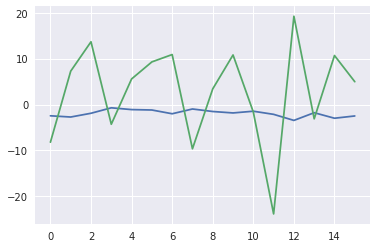

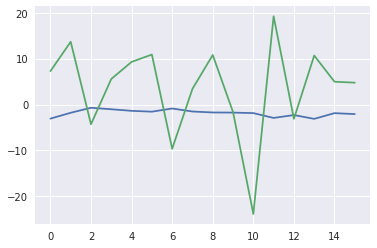

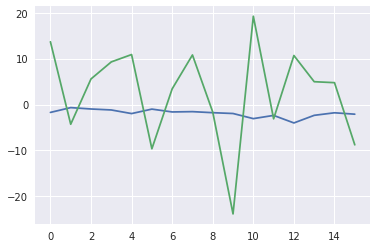

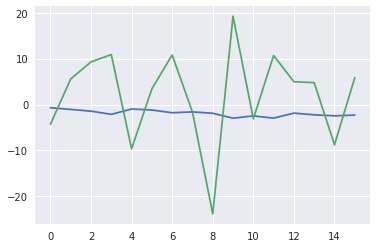

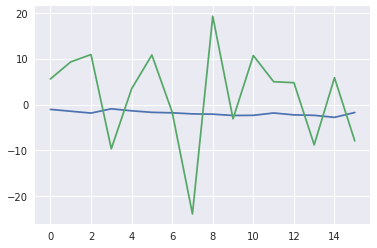

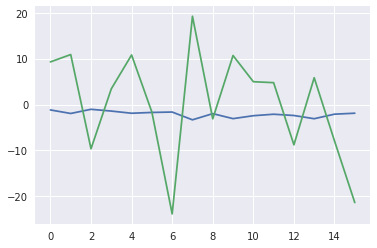

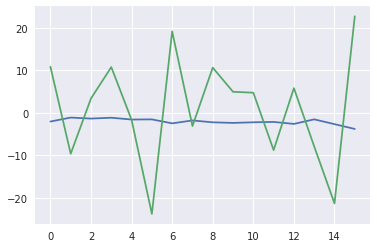

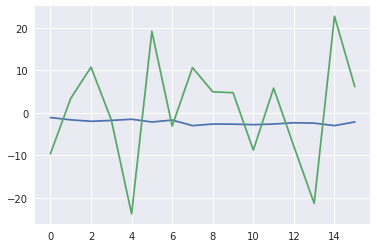

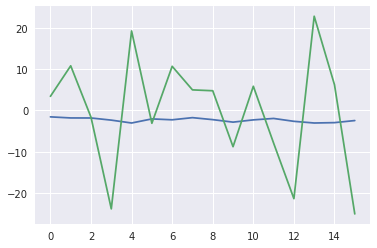

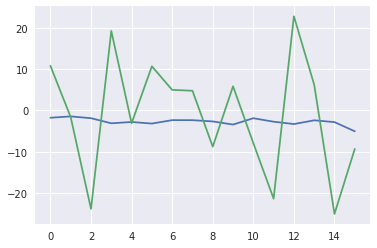

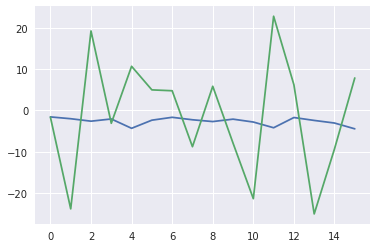

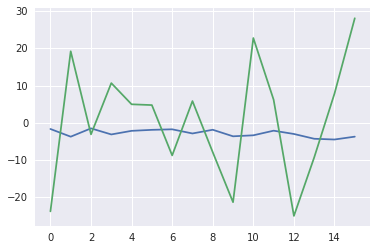

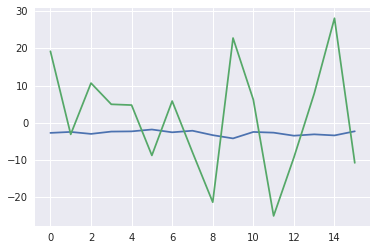

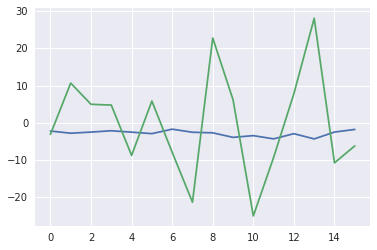

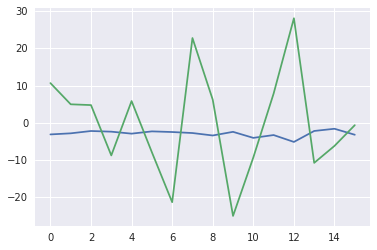

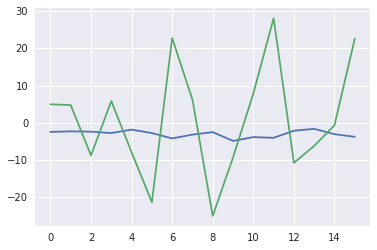

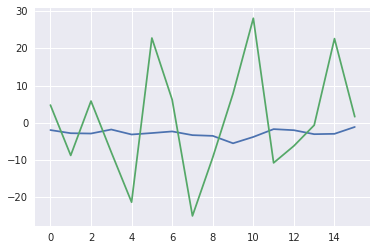

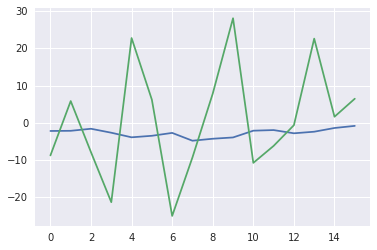

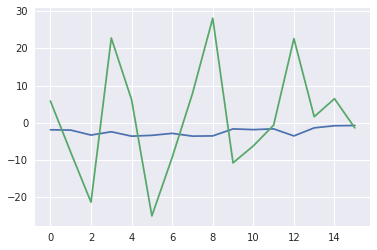

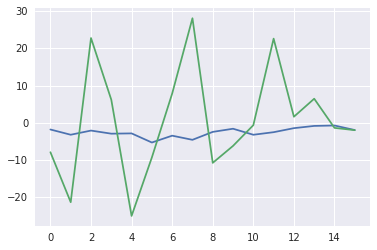

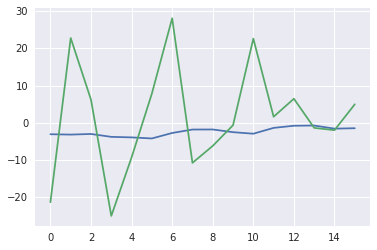

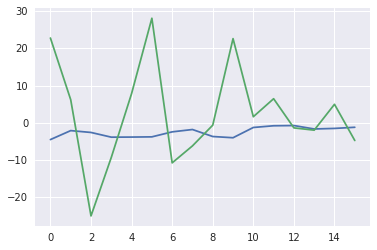

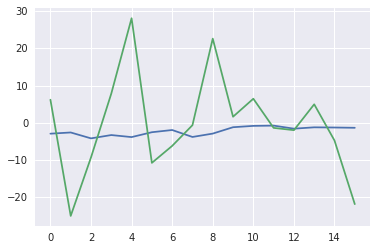

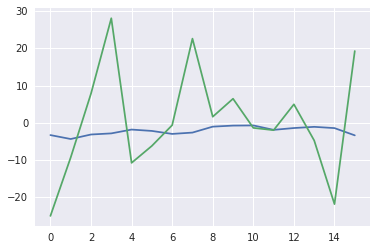

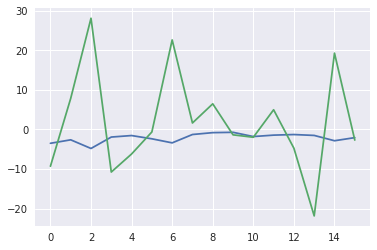

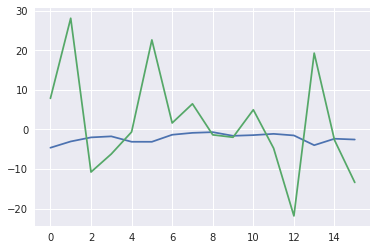

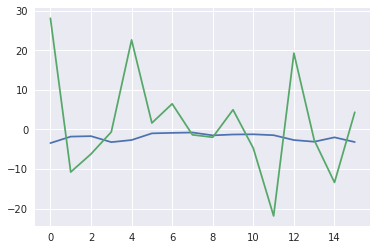

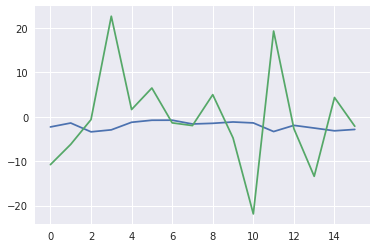

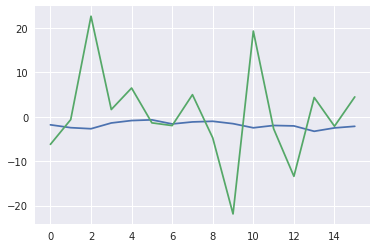

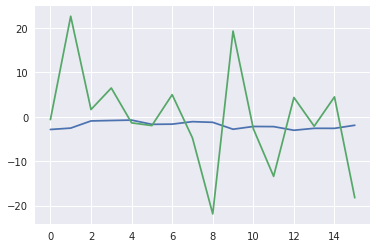

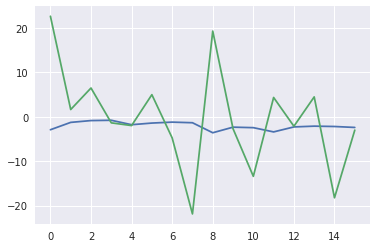

In [59]:
from matplotlib import pyplot as plt
%matplotlib inline

plot_num = 16

for i in range(steps_test):
    start_idx = i*plot_num
    end_idx = (i+1)*plot_num
    plt.figure()
    plt.plot(range(plot_num),y_hat_arr[start_idx:end_idx])
    plt.plot(range(plot_num),y_labels_arr[start_idx:end_idx])
    plt.draw()
    #plt.savefig('./adversarial_training1/range_%i.png' % i)

In [ ]:
## working on a simpler model for prediction

class ts_prediction(object):
    
    def __init__(self, hps):
        self._hps = hps
    
    def _add_placeholder(self):
        self.seq_len = tf.placeholder(tf.int32,[], name = 'seq_len')
        self.input_x = tf.placeholder(dtype = tf.float32, shape = [None, None, input_dim], name = 'enc_input') # b,T,d_in
        self.input_y = tf.placeholder(dtype = tf.float32,shape = [None,self.time_step]) # b,T
        self.label = tf.placeholder(dtype = tf.float32) #b,1
        self.original_loss = tf.placeholder(dtype = tf.float32, shape = [])
        
    def _encoder_LSTM(self,encoder_inputs, seq_len):
        '''Args:
            encoder_inputs: b,T,D
            seq: b,T
        returns: b,T,h
        '''
        with tf.variable_scope('encoder_lstm') as scope:
            try:
                h,state = tf.nn.dynamic_rnn(cell = self._encode_cell, inputs = encoder_inputs, 
                                            sequence_length = seq_len, dtype = tf.float32, scope = 'fw_lstm')
            except ValueError:
                scope.reuse_variables()
                h,last_state = tf.nn.dynamic_rnn(cell = self._encode_cell, inputs = encoder_inputs, 
                                                 sequence_length = seq_len, dtype = tf.float32, scope = 'fw_lstm')
            return [h,last_state]
    
    def _attention_encoder(self, enc_hiddens, enc_last_state, inputs):
        
        hps = self._hps
        with tf.variable_scope('attn_encoder') as scope:
            cell_state = enc_last_state.c # b,enc_hidden
            cell_states = tf.tile(tf.expand_dims(cell_state,axis = 1),[1,self.seq_len,1]) #b,T,enc_hidden
            enc_concat = tf.expand_dims(tf.concat([enc_hiddens,cell_state], axis = -1),2) # b,T,1,2*enc_hidden
            
           
            U_e = tf.get_variable(dtype= tf.float32, shape = [hps.seq_len, hps.seq_len],
                                  initializer = self.rand_unif_init, name = 'U_e') # T,T
            V_e = tf.get_variable(dtype= tf.float32, shape = [hps.seq_len,1],
                                  initializer = self.rand_unif_init, name = 'U_e') # T,T
            broad_V_e = tf.tile(tf.expand_dims(V_e,0),[hps.batch_size,1,1]) # b,T,1
            # Ue*X
            broad_U_e = tf.tile(tf.expand_dims(U_e,0),[hps.batch_size, 1,1]) # b,T,T
            broad_mat = tf.matmul(broad_U_e, inputs) #b,T,D
            # We*[h,s]
            W_e = tf.get_variable(dtype= tf.float32, shape = [1,1,hps.enc_hidden*2, hps.seq_len],
                                  initializer = self.rand_unif_init, name = 'W_e') # 1,1,2*enc_hidden, T
            encoder_features = tf.squeeze(tf.nn.conv2d(enc_concat, fiilter=W_e, strides = [1,1,1,1], padding = 'SAME')) # b,T,T    
            
            attn_dists = []
            for t in range(hps.seq_len):
                e_tk = tf.multiply(broad_V_e,encoder_features[:,t,:] + broad_mat) #b,T,D
                e_t = tf.reduce_sum(e_tk,axis = 1) # b,D
                attn_dist = tf.nn.softmax(e_t)
                attn_dists.append(attn_dist/tf.reduce_sum(attn_dist,axis = 1)) # b,D / b,1 = b,D
            
            return tf.stack(attn_dists, axis = 1) # b,T,D
        
    def build_model(self):
        
        hps = self._hps
        self._add_placeholder()
        
        self.rand_unif_init = tf.random_uniform_initializer(-hps.rand_unif_init_mag, hps.rand_unif_init_mag)
        self.trunc_norm_init = tf.truncated_normal_initializer(stddev=hps.trunc_norm_init_std)
        
        self._encode_cell = tf.contrib.rnn.LSTMCell(hps.enc_hidden, initializer=self.rand_unif_init, state_is_tuple=True)
        self._decoder_cell = tf.contrib.rnn.LSTMCell(hps.dec_hidden, initializer=self.rand_unif_init, state_is_tuple=True)
        
        encoder_outputs, encoder_last_state = self._encoder_LSTM(self.input_x, self.seq_len) # b,T,enc_hidden
        attn_dists = self._attention_encoder(encoder_outputs, encoder_last_state, self.input_x) # b,T,D

In [ ]:
def calc_running_avg_loss(loss, running_avg_loss, summary_writer, step, decay=0.99):
    """Calculate the running average loss via exponential decay.
        This is used to implement early stopping w.r.t. a more smooth loss curve than the raw loss curve.
    Args:
        loss: loss on the most recent eval step
        running_avg_loss: running_avg_loss so far
        summary_writer: FileWriter object to write for tensorboard
        step: training iteration step
        decay: rate of exponential decay, a float between 0 and 1. Larger is smoother.
    Returns:
        running_avg_loss: new running average loss
    """
    if running_avg_loss == 0:  # on the first iteration just take the loss
        running_avg_loss = loss
    else:
        running_avg_loss = running_avg_loss * decay + (1 - decay) * loss
    running_avg_loss = min(running_avg_loss, 12)  # clip
    loss_sum = tf.Summary()
    tag_name = 'running_avg_loss/decay=%f' % (decay)
    loss_sum.value.add(tag=tag_name, simple_value=running_avg_loss)
    summary_writer.add_summary(loss_sum, step)
    
    return running_avg_loss

def get_config():
    '''return config for tf.Session'''
    config = tf.ConfigProto(allow_soft_placement = True)
    config.gpu_options.allow_growth = True
    
    return config